In [56]:
import numpy as np
import h5py as h5
import sys
import time
import matplotlib.pyplot as plt 


In [57]:
# -- visit function for h5 viewing the structure of files
def visit_func(name, node):
    '''
    Return all groups and datasets name and shapes of h5 file called name
    '''
    if isinstance(node, h5.Group):
        print(node.name)
    elif isinstance(node, h5.Dataset):
        if (node.dtype == 'object') :
            print (node.name, 'is an object Dataset')
        else:
            print('\t', node.name, node.shape)
    else:
        print(node.name, 'is an unknown type')
        
def photon_probability(beta,kbar):
    M = 1./beta
    p1 = M*(1+M/kbar)**(-1)*(1+kbar/M)**(-M)
    p2 = M*(M+1)/2*(1+M/kbar)**(-2)*(1+kbar/M)**(-M)
    return p1,p2



In [58]:
ls /sdf/data/lcls/ds/xpp/xppl1001021/hdf5/smalldata

cube/                   xppl1001021_Run0039.h5  xppl1001021_Run0061.h5
jungfrau/               xppl1001021_Run0040.h5  xppl1001021_Run0062.h5
xppl1001021_Run0002.h5  xppl1001021_Run0041.h5  xppl1001021_Run0063.h5
xppl1001021_Run0003.h5  xppl1001021_Run0042.h5  xppl1001021_Run0064.h5
xppl1001021_Run0004.h5  xppl1001021_Run0043.h5  xppl1001021_Run0065.h5
xppl1001021_Run0005.h5  xppl1001021_Run0044.h5  xppl1001021_Run0066.h5
xppl1001021_Run0009.h5  xppl1001021_Run0045.h5  xppl1001021_Run0067.h5
xppl1001021_Run0010.h5  xppl1001021_Run0046.h5  xppl1001021_Run0068.h5
xppl1001021_Run0011.h5  xppl1001021_Run0047.h5  xppl1001021_Run0069.h5
xppl1001021_Run0012.h5  xppl1001021_Run0048.h5  xppl1001021_Run0070.h5
xppl1001021_Run0014.h5  xppl1001021_Run0049.h5  xppl1001021_Run0071.h5
xppl1001021_Run0015.h5  xppl1001021_Run0050.h5  xppl1001021_Run0072.h5
xppl1001021_Run0024.h5  xppl1001021_Run0051.h5  xppl1001021_Run0073.h5
xppl1001021_Run0029.h5  xppl1001021_Run0052.h5  xppl1001021_Run0074.h5
xppl10

In [59]:
exp_name = 'xppl1001021'
run_num=78
output_path = '/sdf/data/lcls/ds/xpp/{}/results/output/'.format(exp_name)


smalldata_path = '/sdf/data/lcls/ds/xpp/{}/hdf5/smalldata/'.format(exp_name)
#smalldata_path = '/sdf/data/lcls/ds/xpp/xppl1001021/results/mb/shared/'.format(exp_name)


In [60]:
with h5.File(smalldata_path + '{}_Run{:04d}.h5'.format(exp_name, run_num),'r') as f:
    print(f.keys())

    #plt.figure()
    #plt.plot(f['jungfrau1M_alcove/azav_azav'][0,0,:])
    
    
    
    #mask = f['UserDataCfg/epix_alc{}/mask'.format(epix)][()]#this is the general mask we use for photonization    


<KeysViewHDF5 ['Sums', 'UserDataCfg', 'ai', 'damage', 'diode2', 'diodeU', 'ebeam', 'epics', 'epicsAll', 'epix_alc1', 'epix_alc1_env', 'epix_alc2', 'epix_alc2_env', 'epix_alc3', 'epix_alc3_env', 'epix_alc4', 'epix_alc4_env', 'epix_alc5', 'epix_alc5_env', 'event_time', 'evr', 'feeBld', 'fiducials', 'ipm2', 'ipm_hx2', 'jungfrau1M_alcove', 'lightStatus', 'lombpm', 'lomdiode', 'scan']>


# Contrast

In [209]:
epix=5
# Define functions
def reconstruct_img(photons_i, photons_j, shape):
    nx, ny = shape
    phot_img, _,_ = np.histogram2d(photons_j+0.5, photons_i+0.5, bins=[np.arange(nx+1),np.arange(ny+1)])                         
    return phot_img

    
# Load the result from droplet analysis
with h5.File(smalldata_path + '{}_Run{:04d}.h5'.format(exp_name, run_num),'r') as f:
    mask = f['UserDataCfg/epix_alc{}/mask'.format(epix)][()]#this is the general mask we use for photonization    
    photons_j = f['epix_alc{}/ragged_droplet_photon_j'.format(epix)][()]
    photons_i = f['epix_alc{}/ragged_droplet_photon_i'.format(epix)][()]
    i_sample = f['lombpm']['channels'][:,1]
    cc = np.array(f['ai/ch03'])
    vcc = np.array(f['ai/ch02'])
    
# Load all the masks
mask = mask.astype(bool)
#user_mask = np.load('/sdf/data/lcls/ds/xpp/xpplx9221/results/kyounes/mask/standard_mask.npy')
#user_mask = user_mask.astype(bool)
mask_user=np.load("/sdf/data/lcls/ds/xpp/xppl1001021/results/shared/mask_epix5.npy")
mask_user=mask_user.astype(bool)
#bad_pixel_mask = np.load('/sdf/data/lcls/ds/xpp/xpplx9221/results/haoyuan/mask_epix{}_combined_hy_v1.npy'.format(epix))

#total_mask = (mask * user_mask * bad_pixel_mask).astype(bool)
total_mask = (mask*mask_user  ).astype(bool)

# Process each pattern in this run
shape = mask.shape
nframe = int(len(photons_i))
#imgs_reconstruct = np.zeros(np.r_[nframe, shape])
    


roi=np.load('/sdf/data/lcls/ds/xpp/xppl1001021/results/shared/roi.npy')    
roi[:,:500]=0
roi_with_mask = roi * total_mask
pixel_num = float(np.sum(roi_with_mask))

# Create holders for the result
kbar = np.zeros(nframe)
beta = np.zeros(nframe)

# Get the total photon count and probability per shot for all runs and patterns
tic = time.time()


p0 = np.zeros(nframe)
p1 = np.zeros(nframe)
p2 = np.zeros(nframe)
p3 = np.zeros(nframe)




for i in range(nframe):
    imgs_reconstruct = reconstruct_img(photons_i[i], photons_j[i], shape)
    kbar[i] = np.sum(imgs_reconstruct[roi_with_mask])/ pixel_num
    beta[i] = np.var(imgs_reconstruct[roi_with_mask].flatten())/(kbar[i])**2
    p, p_bin_edge = np.histogram(imgs_reconstruct[roi_with_mask].flatten(),bins=[-0.5, 0.5, 1.5, 2.5, 3.5])

    p0[i] += p[0] / pixel_num
    p1[i] += p[1] / pixel_num
    p2[i] += p[2] / pixel_num
    p3[i] += p[3] / pixel_num

    if i // 10000 == 0:
        toc = time.time()
        #print(i,toc - tic)
        
# Get the analytical contrast expression

#np.savez(output_path + 'contrast_run_{}_epix_{}'.format(run_num, epix),
#         beta=beta,
#         kbar=kbar,
#         cc=cc,
#         vcc=vcc,
#         i_sample=i_sample)

/tmp/ipykernel_1121667/1864725210.py:60: RuntimeWarning: invalid value encountered in double_scalars
  beta[i] = np.var(imgs_reconstruct[roi_with_mask].flatten())/(kbar[i])**2


Text(0, 0.5, 'diode')

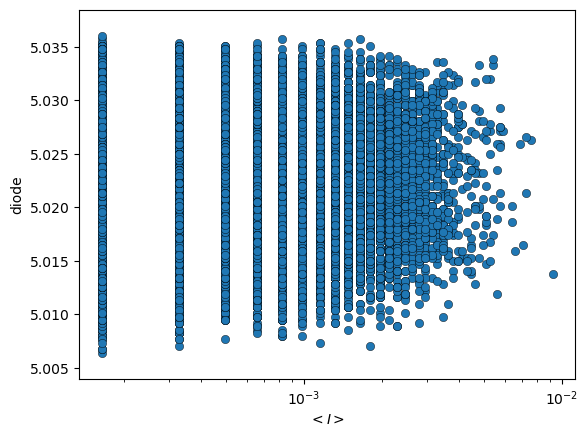

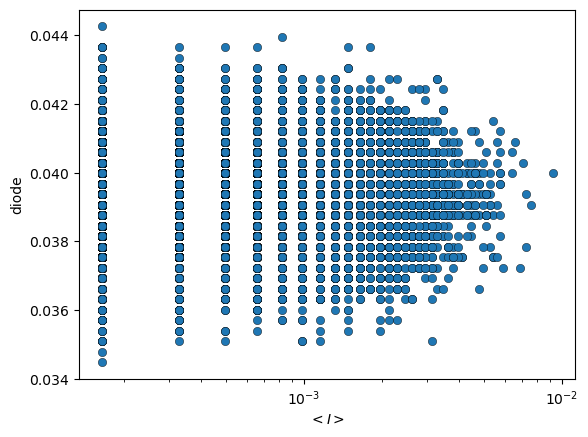

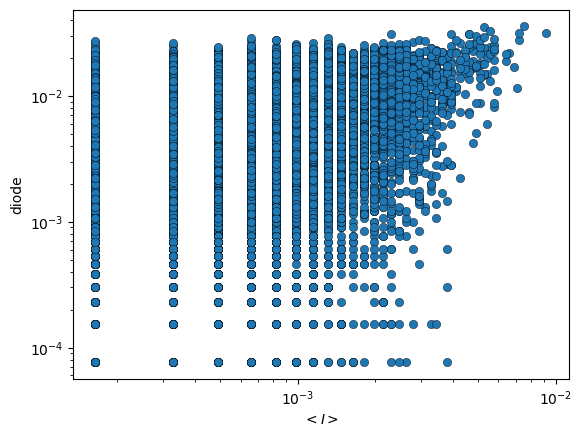

In [234]:
plt.figure()
plt.plot(kbar,cc,marker='o',ls='',mec='k',mew=.3)


plt.xscale('log')
plt.xlabel('$<I>$')
plt.ylabel(r'diode')


plt.figure()
plt.plot(kbar,vcc,marker='o',ls='',mec='k',mew=.3)



plt.xscale('log')
plt.xlabel('$<I>$')
plt.ylabel(r'diode')
#plt.ylim(0,10)

plt.figure()
plt.plot(kbar,i_sample,marker='o',ls='',mec='k',mew=.3)


plt.yscale('log')
plt.xscale('log')
plt.xlabel('$<I>$')
plt.ylabel(r'diode')
#plt.ylim(0,10)

Text(0, 0.5, '$\\beta_{var}$')

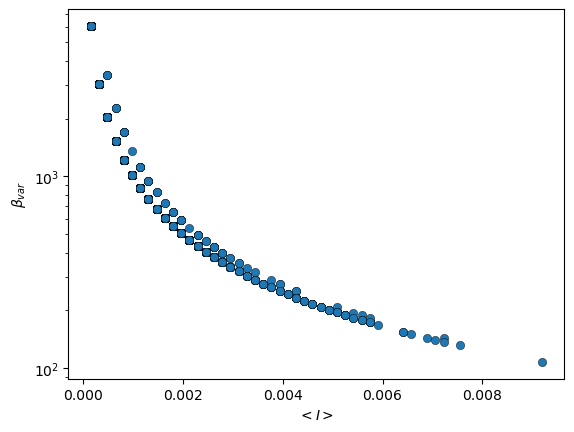

In [233]:
plt.figure()
plt.plot(kbar,beta,marker='o',ls='',mec='k',mew=.3)


plt.yscale('log')
plt.xlabel('$<I>$')
plt.ylabel(r'$\beta_{var}$')

#plt.ylim(0,10)

In [186]:
def photon_probability(beta,kbar):
    M = 1./beta
    p1 = M*(1+M/kbar)**(-1)*(1+kbar/M)**(-M)
    p2 = M*(M+1)/2*(1+M/kbar)**(-2)*(1+kbar/M)**(-M)
    return p1,p2


(0.002, 0.06)

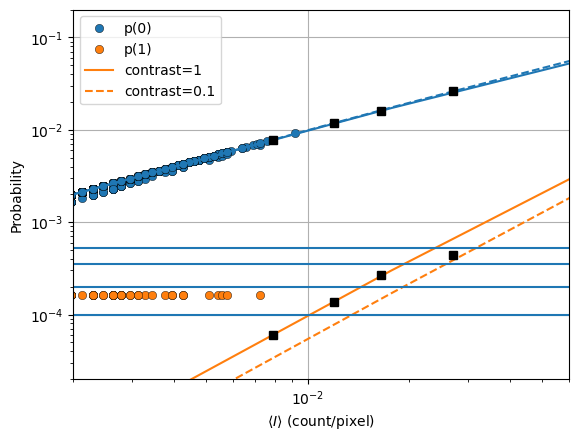

In [235]:

kbar_est = np.logspace(-4,-1,5)

contrast0=1
contrast1=.1


p1_0,p2_0 = photon_probability(contrast0,kbar_est)
p1_1,p2_1 = photon_probability(contrast1,kbar_est)

plt.figure()
#plt.plot(kbar,p0,marker='o',ls='')
plt.plot(kbar,p1,marker='o',ls='',color='C0',label='p(0)',mec='k',mew=.3)
plt.plot(kbar,p2,marker='o',ls='',color='C1',label='p(1)',mec='k',mew=.3)
#plt.plot(kbar,p3,marker='o',ls='')

plt.plot(kbar_est,p1_0,color='C0')
plt.plot(kbar_est,p2_0,color='C1',label='contrast='+str(contrast0))

plt.plot(kbar_est,p1_1,color='C0',ls='dashed')
plt.plot(kbar_est,p2_1,color='C1',ls='dashed',label='contrast='+str(contrast1))

plt.plot(kbar_rebinned,p2_rebinned,marker='s',ls='',c='k')
plt.plot(kbar_rebinned,p1_rebinned,marker='s',ls='',c='k')

plt.hlines([1e-4,2e-4,3.5e-4,5.2e-4,],0,1)

plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.legend()
plt.ylabel('Probability')
plt.xlabel(r'$\langle I \rangle$ (count/pixel)')
plt.ylim(2e-5,2e-1)
plt.xlim(2e-3,6e-2)

#plt.ylim(0,10)

In [172]:
thresholds=[0,1e-4,2e-4,3.5e-4,5.2e-4,]
p1_rebinned,p2_rebinned,kbar_rebinned =[],[],[]
for i in range(1,len(thresholds)):
    kbar_rebinned.append(np.mean(kbar[(p2>thresholds[i-1])&(p2<thresholds[i])]))
    p2_rebinned.append(np.mean(p2[(p2>thresholds[i-1])&(p2<thresholds[i])]))
    p1_rebinned.append(np.mean(p1[(p2>thresholds[i-1])&(p2<thresholds[i])]))
    
kbar_rebinned=np.array(kbar_rebinned)   
p1_rebinned=np.array(p1_rebinned)
p2_rebinned=np.array(p2_rebinned)  

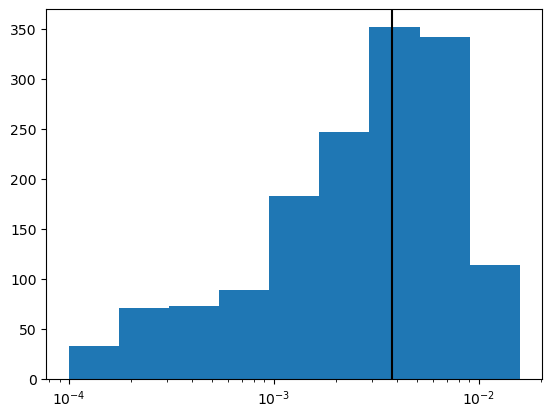

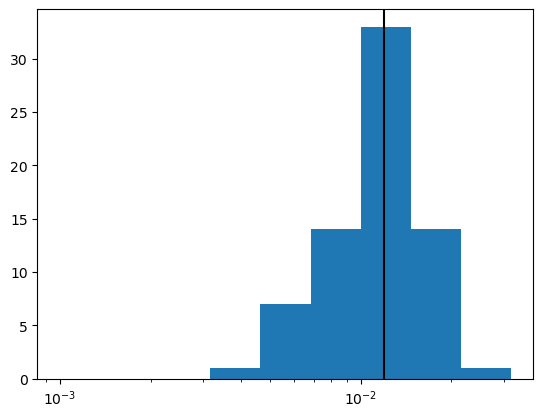

In [173]:






plt.figure()
plt.hist(kbar[p2<1e-4],bins=np.logspace(-4,-1.8,10))
plt.axvline(x=np.mean(kbar[(p2<1e-4)]),color='k')
plt.xscale('log')



plt.figure()
plt.hist(kbar[(p2>1e-4)&(p2<2e-4)],bins=np.logspace(-3,-1.5,10))
plt.axvline(x=np.mean(kbar[(p2>1e-4)&(p2<2e-4)]),color='k')
plt.xscale('log')

Text(0, 0.5, '$\\beta_{formula}$')

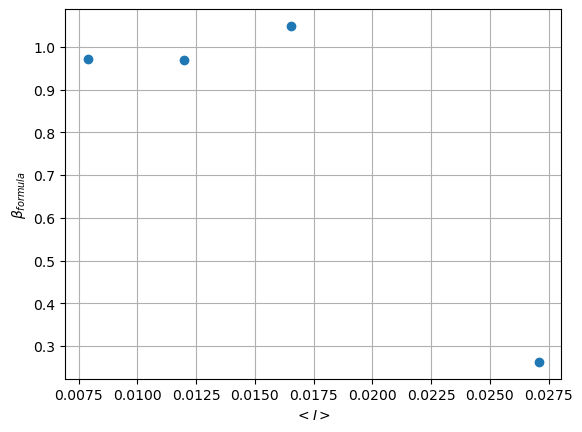

In [188]:
beta_for = (2 * p2_rebinned - kbar_rebinned * p1_rebinned) / (kbar_rebinned * (p1_rebinned - 2 * p2_rebinned))
plt.figure()
plt.plot(kbar_rebinned,beta_for,marker='o',ls='')
plt.grid('on')

plt.xlabel('$<I>$')
plt.ylabel(r'$\beta_{formula}$')


# I(q)

In [50]:
run_num=80
epix=5
# Define functions
def reconstruct_img(photons_i, photons_j, shape):
    nx, ny = shape
    phot_img, _,_ = np.histogram2d(photons_j+0.5, photons_i+0.5, bins=[np.arange(nx+1),np.arange(ny+1)])                         
    return phot_img

    
# Load the result from droplet analysis
with h5.File(smalldata_path + '{}_Run{:04d}.h5'.format(exp_name, run_num),'r') as f:
    mask = f['UserDataCfg/epix_alc{}/mask'.format(epix)][()]#this is the general mask we use for photonization    
    photons_j = f['epix_alc{}/ragged_droplet_photon_j'.format(epix)][()]
    photons_i = f['epix_alc{}/ragged_droplet_photon_i'.format(epix)][()]
    i_sample = f['lombpm']['channels'][:,1]
    cc = np.array(f['ai/ch03'])
    vcc = np.array(f['ai/ch02'])
    
roi=np.load('/sdf/data/lcls/ds/xpp/xppl1001021/results/shared/roi.npy')    
roi[:,:500]=0

In [53]:
shape=mask.shape
nframe=len(photons_i)
i=0
imgs_reconstructed =np.zeros([nframe,shape[0],shape[1]])
for i in range(10):
    imgs_reconstructed = reconstruct_img(photons_i[i], photons_j[i], shape)
    np.save(f'/sdf/data/lcls/ds/xpp/xppl1001021/results/mb/npys/usuck_img_run80_frame{i}.npy',imgs_reconstructed)


In [66]:
shape

(704, 768)

In [67]:

def circle(radius,radius2, xcenter,ycenter, shape):
    
    c=np.ones([shape[0],shape[1],])
    
    for x in range(shape[0]):
        for y in range(shape[1]):
            if (((x-xcenter)**2+(y-ycenter)**2)<radius**2)&(((x-xcenter)**2+(y-ycenter)**2)>radius2**2):
                c[x,y]=0
                
                
    return c
mask=circle(radius=220,radius2=150, xcenter=353,ycenter=350, shape=shape)

mask=mask.astype('bool')
mask=~mask

#np.save('/sdf/data/lcls/ds/xpp/xppl1001021/results/shared/roi_02.npy',mask)

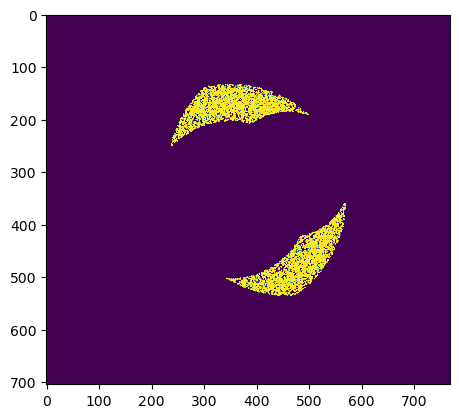

In [68]:


plt.figure()
plt.imshow(imgs_reconstructed*mask,vmax=.1,vmin=0)



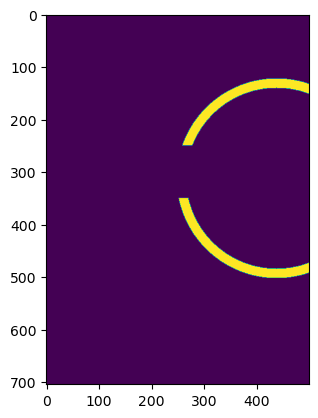

In [206]:
plt.figure()
plt.imshow(roi[:,:500])

In [28]:
import pyFAI


ai=pyFAI.load('/sdf/data/lcls/ds/xpp/xppl1001021/results/shared/poni/xppl1001021_Run0024_epix5_poni.poni')

Text(0.5, 0, '$\\phi$')

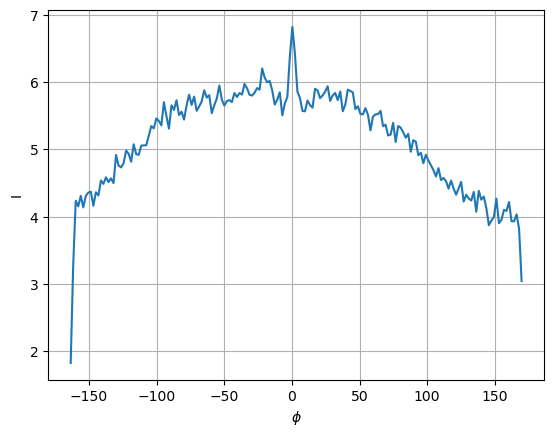

In [112]:
mask_user=np.load("/sdf/data/lcls/ds/xpp/xppl1001021/results/shared/mask_epix5.npy")
mask_user=mask_user.astype(bool)
I,q,phi,=ai.integrate2d(imgs_reconstructed, npt_rad=100, npt_azim=180,mask=~mask_user)
plt.figure()

plt.plot(phi,np.mean(I[:,40:-10],axis=1))
plt.grid()
plt.ylabel('I')
plt.xlabel(r'$\phi$')

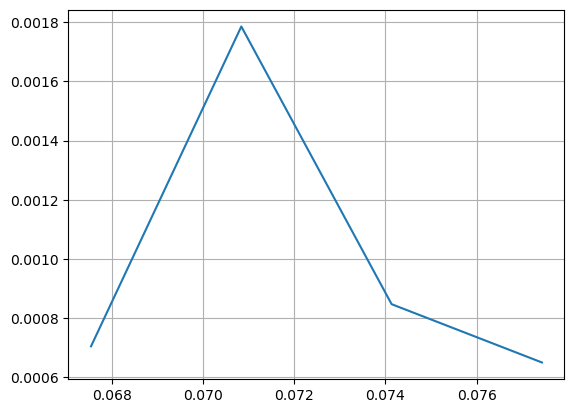

In [95]:
plt.figure()
Imean=np.mean(I,axis=0)
plt.plot(q[Imean>0],Imean[Imean>0])
plt.grid()

In [66]:
q[30:-10]

array([0.08085447, 0.08172593, 0.08259739, 0.08346885, 0.08434031,
       0.08521177, 0.08608323, 0.08695469, 0.08782615, 0.08869761,
       0.08956907, 0.09044053, 0.09131199, 0.09218345, 0.09305492,
       0.09392638, 0.09479784, 0.0956693 , 0.09654076, 0.09741222,
       0.09828368, 0.09915514, 0.1000266 , 0.10089806, 0.10176952,
       0.10264098, 0.10351244, 0.1043839 , 0.10525536, 0.10612682,
       0.10699828, 0.10786975, 0.10874121, 0.10961267, 0.11048413,
       0.11135559, 0.11222705, 0.11309851, 0.11396997, 0.11484143,
       0.11571289, 0.11658435, 0.11745581, 0.11832727, 0.11919873,
       0.12007019, 0.12094165, 0.12181311, 0.12268457, 0.12355604,
       0.1244275 , 0.12529896, 0.12617042, 0.12704188, 0.12791334,
       0.1287848 , 0.12965626, 0.13052772, 0.13139918, 0.13227064])